In [ ]:
!pip install elephant neo

In [95]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2

from elephant.kernels import GaussianKernel
from elephant.statistics import instantaneous_rate
from quantities import ms
import matplotlib.pyplot as plt
import neo
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from scipy.signal import savgol_filter

import pickle

pca_n=5
s_interval=10

spikes, position = pickle.load(open('rat-hippocampus-single-buddy.pkl','rb'))
position = position[:,[0]]
spikes = spikes.T

gk = GaussianKernel(100 * ms)
rates = []
for sp in spikes:
    sp_times = np.where(sp)[0]
    st = neo.SpikeTrain(sp_times, units="ms", t_stop=len(sp))
    r = instantaneous_rate(st, kernel=gk, sampling_period=s_interval * ms).magnitude
    rates.append(r.T)
    
rates = np.vstack(rates)

pipeline = Pipeline([('scaling', StandardScaler(with_std=True)), 
                     ('pca', PCA(n_components=pca_n))])
rates_pca = pipeline.fit_transform(rates.T)
print(pipeline[1].explained_variance_ratio_)

pos = position[::10][:-1]
vel_rates_pca = np.diff(rates_pca, axis=0)
rates_pca = rates_pca[:-1,:]
pos = pos[:-1,:]

vel = savgol_filter(pos, 10, 2, deriv=1, axis=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[0.27653801 0.11224131 0.10674935 0.08470539 0.05456087]


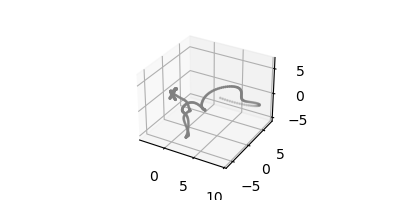

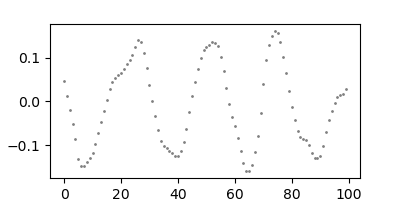

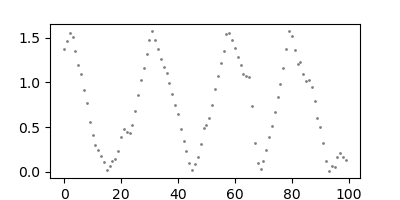

In [96]:
fig = plt.figure(figsize=(4, 2))
ax = plt.subplot(111, projection='3d')
ax.scatter(rates_pca[:500,0], rates_pca[:500,1], rates_pca[:500,2], c = 'gray', s=1)

fig = plt.figure(figsize=(4, 2))
plt.scatter(np.arange(100), vel[:100], c = 'gray', s=1)

fig = plt.figure(figsize=(4, 2))
plt.scatter(np.arange(100), pos[:100], c = 'gray', s=1)

In [97]:
import MARBLE

data = MARBLE.construct_dataset(
            np.hstack([pos, rates_pca]),
            features=np.hstack([vel, vel_rates_pca]),
            k=5,
            stop_crit=0.01,
            delta=1.0,
            compute_laplacian=True,
            local_gauges=False,
            number_of_resamples=3,
        )

---- Embedding dimension: 6
---- Signal dimension: 6


---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 


In [80]:
#from MARBLE import plotting
#plotting.fields(data)

In [98]:
params = {
            "epochs": 100,  # optimisation epochs
            "order": 2,  # order of derivatives
            "lr": 0.1,
            "batch_size": 64,
            "hidden_channels": 32,  # number of internal dimensions in MLP
            "out_channels": 8, 
            "inner_product_features": False,
            "vec_norm": False,
            "diffusion": True,
          }

model = MARBLE.net(data, params=params)

model.run_training(data, outdir="data/hippocampus_achilles")
data = model.evaluate(data)


---- Settings: 

epochs : 100
order : 2
lr : 0.1
batch_size : 64
hidden_channels : [32]
out_channels : 8
inner_product_features : False
vec_norm : False
diffusion : True
momentum : 0.9
frac_sampled_nb : -1
include_positions : False
include_self : True
dropout : 0.0
bias : True
batch_norm : None
seed : 0
processes : 1
dim_signal : 6
dim_emb : 6
n_sampled_nb : -1

---- Number of features to pass to the MLP:  258
---- Total number of parameters:  8553

---- Training network ...

Epoch: 0, Training loss: 1.386880, Validation loss: 1.3858, lr: 0.1000 *
Epoch: 1, Training loss: 1.385873, Validation loss: 1.3857, lr: 0.1000 *
Epoch: 2, Training loss: 1.385752, Validation loss: 1.3856, lr: 0.1000 *
Epoch: 3, Training loss: 1.385637, Validation loss: 1.3855, lr: 0.1000 *
Epoch: 4, Training loss: 1.385391, Validation loss: 1.3855, lr: 0.1000
Epoch: 5, Training loss: 1.385288, Validation loss: 1.3852, lr: 0.1000 *
Epoch: 6, Training loss: 1.384571, Validation loss: 1.3852, lr: 0.1000 *
Epoch: 7,

Performed umap embedding on embedded results.


<AxesSubplot:>

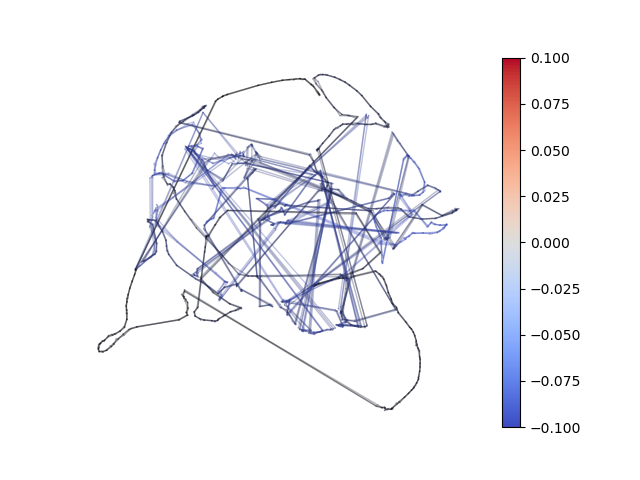

In [99]:
from MARBLE import geometry
data.emb_2D, _ = geometry.embed(data.emb, 
                                embed_typ="umap", 
                                dim_emb=2, min_dist=0.2, n_neighbors=30,
                                seed=0)

#plot correct trials with error trials on top
plotting.embedding(data, labels=np.array(data.y)*1., plot_trajectories=True, s=8, style='-', time_gradient=True)